In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.tokenize import RegexpTokenizer

In [2]:
# Load rating file
df_ratings = pd.read_csv('./ratings.dat', sep='::', engine='python', names=['user_id', 'item_id', 'rating', 'time_stamp'])

In [4]:
# # Load user and item file, join with rating
# df_user = pd.read_csv('./users.dat', sep='::', engine='python', names=['user_id', 'gender', 'age', 'occupation', 'zip-code'])
# df_item = pd.read_csv('./movies.dat', sep='::', engine='python', names=['item_id', 'title', 'genres'])
# df_ratings = df_ratings.join(df_user.set_index('user_id'), on='user_id')
# df_ratings = df_ratings.join(df_item.set_index('item_id'), on='item_id')

# Load user and item file with latin1 encoding
df_user = pd.read_csv('./users.dat', sep='::', engine='python', names=['user_id', 'gender', 'age', 'occupation', 'zip-code'], encoding='latin1')
df_item = pd.read_csv('./movies.dat', sep='::', engine='python', names=['item_id', 'title', 'genres'], encoding='latin1')
df_ratings = df_ratings.join(df_user.set_index('user_id'), on='user_id')
df_ratings = df_ratings.join(df_item.set_index('item_id'), on='item_id')

In [5]:
# Preprocess rating and gender
df_ratings['rating'] = df_ratings['rating'].map(lambda x: 0 if x < 4 else 1)
df_ratings['gender'] = df_ratings['gender'].map(lambda x: 0 if x == 'F' else 1)

In [6]:
# Preprocess zip-code
zip_codes = list(set(df_ratings['zip-code']))
print("number of zip code: {}, number of users: {}".format(len(zip_codes), len(set(df_ratings['user_id']))))
zip_code2idx = {}
for idx, value in enumerate(zip_codes):
    zip_code2idx[value] = idx
df_ratings['zip-code'] = df_ratings['zip-code'].map(lambda x: zip_code2idx[x])

number of zip code: 3439, number of users: 6040


In [7]:
# Preprocess year
titles = df_ratings['title']

years = [title[-5:-1] for title in titles]
year_set = list(set(years))
year_set.sort()
year2idx = {y: idx for idx, y in enumerate(year_set)}
years = [year2idx[y] for y in years]
df_ratings['year'] = years

In [8]:
# Preprocess genre
genres = df_ratings['genres']
genre2idx = {}
cnt = 1
res_genre = []
max_genre_len = 0
for genre in list(genres):
    l = genre.split('|')
    max_genre_len = max_genre_len if max_genre_len > len(l) else len(l)
    for e in l:
        if e not in genre2idx:
            genre2idx[e] = cnt
            cnt += 1
    res_genre.append([genre2idx[e] for e in l])
for genre in res_genre:
    genre.extend([0 for i in range(max_genre_len - len(genre))])
df_ratings['genres'] = res_genre

In [9]:
# Preprocess titles
tokenizer = RegexpTokenizer(r'\w+')
titles = df_ratings['title']
tokenized_titles = []
titles = [tokenizer.tokenize(str(title[:-6])) for title in list(titles)]
vocab = []
max_title_len = 0
for title in titles:
    vocab += title
    max_title_len = max_title_len if max_title_len > len(title) else len(title)
vocab = set(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}
res_title = []
for title in titles:
    padding_title = [word2idx[word] for word in title]
    padding_title.extend([0 for i in range(max_title_len - len(title))])
    res_title.append(padding_title)
df_ratings['title'] = res_title

In [10]:
# Reorder the columns 
orders = ['user_id', 'gender', 'age', 'occupation', 'zip-code', 'item_id', 'year', 'title', 'genres', 'time_stamp', 'rating']
df_ratings = df_ratings[orders]
description = [
    ('user_id', 1 + np.max(df_ratings['user_id']), 'spr'),
    ('gender', 1 + np.max(df_ratings['gender']), 'spr'),
    ('age', 1 + np.max(df_ratings['age']), 'spr'),
    ('occupation', 1 + np.max(df_ratings['occupation']), 'spr'),
    ('zip-code', 1 + np.max(df_ratings['zip-code']), 'spr'),
    ('item_id', 1 + np.max(df_ratings['item_id']), 'spr'),
    ('year', 1 + np.max(df_ratings['year']), 'spr'),
    ('title', 1 + np.max(list(df_ratings['title'])), 'seq'),
    ('genres', 1 + np.max(list(df_ratings['genres'])), 'seq'),
    ('time_stamp', -1, 'ctn'),
    ('rating', 2, 'label'),
    ('count', -1, 'ctn')
]
description

[('user_id', 6041, 'spr'),
 ('gender', 2, 'spr'),
 ('age', 57, 'spr'),
 ('occupation', 21, 'spr'),
 ('zip-code', 3439, 'spr'),
 ('item_id', 3953, 'spr'),
 ('year', 81, 'spr'),
 ('title', 4373, 'seq'),
 ('genres', 19, 'seq'),
 ('time_stamp', -1, 'ctn'),
 ('rating', 2, 'label'),
 ('count', -1, 'ctn')]

In [11]:
# Preprocess timestamp
min_time_stamp = np.min(df_ratings['time_stamp'])
max_time_stamp = np.max(df_ratings['time_stamp'])

df_ratings['time_stamp'] = df_ratings['time_stamp'].map(lambda x: (x - min_time_stamp)/(max_time_stamp - min_time_stamp))
df_ratings = df_ratings.sort_values(by='time_stamp')

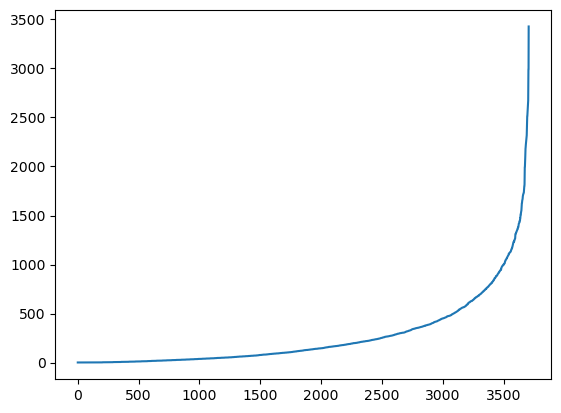

In [12]:
# plot item counts vs item
user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['item_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [13]:
# Preprocess count
df_ratings = df_ratings.join(user2count.set_index('item_id'), on='item_id')
min_count = np.min(df_ratings['count'])
max_count = np.max(df_ratings['count'])
df_ratings['count'] = df_ratings['count'].map(lambda x: (x - min_count)/(max_count - min_count))

In [13]:
def split_0():
    # split train, test, validation dataset
    user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = list(user2count['item_id'])
    counts = np.array(user2count['count'])

    itemid_group = df_ratings.groupby('item_id')
    # split insufficient and sufficient items
    item_ids = item_ids[870:] # select items with more than 30 samples
    cold_items = item_ids[:int(len(item_ids) * 0.2)] # choose the 20% items at tail as cold items
    warm_items = item_ids[int(len(item_ids) * 0.2):] # choose the 80% items at head as warm items

    train_a = pd.DataFrame()
    train_b = pd.DataFrame()
    train_c = pd.DataFrame()
    val_a_cold, val_a_warm = pd.DataFrame(), pd.DataFrame()
    val_b_cold, val_b_warm = pd.DataFrame(), pd.DataFrame()
    val_c_cold, val_c_warm = pd.DataFrame(), pd.DataFrame()
    test_cold, test_warm = pd.DataFrame(), pd.DataFrame()

    for item_id in cold_items:
        df_samples = itemid_group.get_group(item_id).sort_values(by='time_stamp')
        size = len(df_samples)
        train_a = train_a.append(df_samples.iloc[:(size * 8 // 30)], ignore_index=True)
        val_a_cold = val_a_cold.append(df_samples.iloc[(size * 8 // 30):(size * 9 // 30)], ignore_index=True)
        train_b = train_b.append(df_samples.iloc[(size * 9 // 30):(size * 17 // 30)], ignore_index=True)
        val_b_cold = val_b_cold.append(df_samples.iloc[(size * 17 // 30):(size * 18 // 30)], ignore_index=True)
        train_c = train_c.append(df_samples.iloc[(size * 18 // 30):(size * 26 // 30)], ignore_index=True)
        val_c_cold = val_c_cold.append(df_samples.iloc[(size * 26 // 30):(size * 27 // 30)], ignore_index=True)
        test_cold = test_cold.append(df_samples.iloc[(size * 27 // 30):], ignore_index=True)

    for item_id in warm_items:
        df_samples = itemid_group.get_group(item_id).sort_values(by='time_stamp')
        size = len(df_samples)
        train_a = train_a.append(df_samples.iloc[:(size * 8 // 30)], ignore_index=True)
        val_a_warm = val_a_warm.append(df_samples.iloc[(size * 8 // 30):(size * 9 // 30)], ignore_index=True)
        train_b = train_b.append(df_samples.iloc[(size * 9 // 30):(size * 17 // 30)], ignore_index=True)
        val_b_warm = val_b_warm.append(df_samples.iloc[(size * 17 // 30):(size * 18 // 30)], ignore_index=True)
        train_c = train_c.append(df_samples.iloc[(size * 18 // 30):(size * 26 // 30)], ignore_index=True)
        val_c_warm = val_c_warm.append(df_samples.iloc[(size * 26 // 30):(size * 27 // 30)], ignore_index=True)
        test_warm = test_warm.append(df_samples.iloc[(size * 27 // 30):], ignore_index=True)

    print("cold item number: {}; warm item number: {}".format(len(cold_items), len(warm_items)))
    print("train_a size: ", len(train_a))
    print("train_b size: ", len(train_b))
    print("train_c size: ", len(train_c))
    print("val_a_cold size: ", len(val_a_cold))
    print("val_b_cold size: ", len(val_b_cold))
    print("val_c_cold size: ", len(val_c_cold))
    print("val_a_warm size: ", len(val_a_warm))
    print("val_b_warm size: ", len(val_b_warm))
    print("val_c_warm size: ", len(val_c_warm))
    print("test_cold size: ", len(test_cold))
    print("test_warm size: ", len(test_warm))

    save_dic = {
        'train_a': train_a,
        'train_b': train_b,
        'train_c': train_c,
        'val_a_cold': val_a_cold,
        'val_a_warm': val_a_warm,
        'val_b_cold': val_b_cold,
        'val_b_warm': val_b_warm,
        'val_c_cold': val_c_cold,
        'val_c_warm': val_c_warm,
        'test_cold': test_cold,
        'test_warm': test_warm,
        'params': {
            'sparse_feature_dims': sparse_feature_dims,
            'continuous_feature_num': continuous_feature_num,
            'seq_feature_vocab_size': [title_vocab_size, genre_vocab_size]
        }
    }
    with open('./cold_start/preprocess_ml-1M.pkl', 'bw+') as f:
        pickle.dump(save_dic, f)

    # Check the validation of data saved to file
    with open('./cold_start/preprocess_ml-1M.pkl', 'br+') as f:
        data = pickle.load(f)
    for key in data.keys():
        if key != 'params':
            assert data[key].equals(save_dic[key])
        else:
            assert data['params'] == save_dic['params']

In [14]:
def split_1():
    df_ratings = df_ratings.sample(frac=1).reset_index(drop=True)
    train_df = df_ratings.iloc[:int(len(df_ratings)*0.8), :]
    val_df = df_ratings.iloc[int(len(df_ratings)*0.8):int(len(df_ratings)*0.9), :]
    test_df = df_ratings.iloc[int(len(df_ratings)*0.9):, :]
    save_dic = {
        'train': train_df,
        'val': val_df,
        'test': test_df,
        'params': {
            'sparse_feature_dims': sparse_feature_dims,
            'continuous_feature_num': continuous_feature_num,
            'seq_feature_vocab_size': [title_vocab_size, genre_vocab_size]
        }
    }
    with open('./normal_preprocess_ml-1M.pkl', 'bw+') as f:
        pickle.dump(save_dic, f)

In [17]:
def split_2(df_ratings, description, N = 200, K = 20):
    user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = list(user2count['item_id'])
    counts = np.array(user2count['count'])

    item_ids, counts = np.asarray(item_ids), np.asarray(counts)
    hot_item_ids = item_ids[counts > N]
    cold_item_ids = item_ids[np.logical_and(counts <= N, counts >= 3 * K)]
    item_group = df_ratings.groupby('item_id')
    train_base = pd.DataFrame()
    for item_id in hot_item_ids:
        df_hot = item_group.get_group(item_id).sort_values(by='time_stamp')
        # train_base = train_base.append(df_hot, ignore_index=True)
        dfs = [train_base, df_hot]
        train_base = pd.concat(dfs, ignore_index=True)
    train_warm_a, train_warm_b, train_warm_c, test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for item_id in cold_item_ids:
        df_cold = item_group.get_group(item_id).sort_values(by='time_stamp')
        # train_warm_a = train_warm_a.append(df_cold[: K], ignore_index=True)
        # train_warm_b = train_warm_b.append(df_cold[K: 2*K], ignore_index=True)
        # train_warm_c = train_warm_c.append(df_cold[2*K: 3*K], ignore_index=True)
        # test = test.append(df_cold[3*K:], ignore_index=True)
        train_warm_a = pd.concat([train_warm_a, df_cold[:K]], ignore_index=True)
        train_warm_b = pd.concat([train_warm_b, df_cold[K: 2*K]], ignore_index=True)
        train_warm_c = pd.concat([train_warm_c, df_cold[2*K: 3*K]], ignore_index=True)
        test = pd.concat([test, df_cold[3*K:]], ignore_index=True)
    save_dic = {
        'train_base': train_base.sort_values('time_stamp'),
        'train_warm_a': train_warm_a.sort_values('time_stamp'),
        'train_warm_b': train_warm_b.sort_values('time_stamp'),
        'train_warm_c': train_warm_c.sort_values('time_stamp'),
        'test': test.sort_values('time_stamp'),
        'description': description
    }
    for name, df in save_dic.items():
        print("{} size: {}".format(name, len(df)))
    with open('./emb_warm_split_preprocess_ml-1M.pkl', 'bw+') as f:
        pickle.dump(save_dic, f)

In [19]:
split_2(df_ratings, description)

train_base size: 854530
train_warm_a size: 19440
train_warm_b size: 19440
train_warm_c size: 19440
test size: 58409
description size: 12


In [21]:
# Get training data for Meta-Embedding method
with open('./emb_warm_split_preprocess_ml-1M.pkl', 'rb+') as f:
    data = pickle.load(f)
df_base = data['train_base']
item2group = df_base.groupby('item_id')
train_a, train_b, train_c, train_d = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for item_id, df_group in item2group:
    l, e = df_group.shape[0], df_group.shape[0] // 4     
    # train_a = train_a.append(df_group.iloc[0: e,], ignore_index=True)
    # train_b = train_b.append(df_group.iloc[e: 2 * e, ], ignore_index=True)
    # train_c = train_c.append(df_group.iloc[2 * e: 3 * e, ], ignore_index=True)
    # train_d = train_d.append(df_group.iloc[3 * e: 4 * e, ], ignore_index=True)
    train_a = pd.concat([train_a, df_group.iloc[0: e,]], ignore_index=True)
    train_b = pd.concat([train_b, df_group.iloc[e: 2 * e,]], ignore_index=True)
    train_c = pd.concat([train_c, df_group.iloc[2 * e: 3 * e,]], ignore_index=True)
    train_d = pd.concat([train_d, df_group.iloc[3 * e: 4 * e,]], ignore_index=True)
shuffle_idx = np.random.permutation(train_a.shape[0])
train_a = train_a.iloc[shuffle_idx]
train_b = train_b.iloc[shuffle_idx]
train_c = train_c.iloc[shuffle_idx]
train_d = train_d.iloc[shuffle_idx]
data["metaE_a"] = train_a
data["metaE_b"] = train_b
data["metaE_c"] = train_c
data["metaE_d"] = train_d
with open('./movielens1M_data.pkl', 'wb+') as f:
    pickle.dump(data, f)